# Analysis of deltaH Approximations vs True Values

This notebook analyzes the accuracy of linear and linear+quadratic approximations to deltaH_true,
excluding η₀ (due to numerical precision issues) but including large η values to test quadratic corrections.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from scipy import stats
import seaborn as sns

# Set up matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Loading and Preprocessing

In [2]:
# Load all run results
results_dir = Path('..')  # Parent directory since we're in notebooks/
runs_data = {}

for run_id in range(1, 9):
    run_dir = results_dir / f'run_{run_id:02d}'
    results_file = run_dir / 'results.json'
    
    if results_file.exists():
        with open(results_file, 'r') as f:
            runs_data[f'run_{run_id:02d}'] = json.load(f)
        print(f"Loaded run_{run_id:02d}")

print(f"\nTotal runs loaded: {len(runs_data)}")

Loaded run_01
Loaded run_02
Loaded run_03
Loaded run_04
Loaded run_05
Loaded run_06
Loaded run_07
Loaded run_08

Total runs loaded: 8


In [3]:
# Extract and organize data, excluding η₀
all_data = []

for run_name, data in runs_data.items():
    sweep = data['sweep'][1:]  # Skip η₀
    curvature = data.get('curvature', {})
    
    for item in sweep:
        eta = item['eta']
        record = {
            'run': run_name,
            'eta': eta,
            'deltaH_true': abs(item['deltaH_true']),
            'deltaH_linear': abs(item['deltaH_approx_linear']),
            'deltaH_linquad': abs(item['deltaH_approx_linquad']),
            'eta_star': curvature.get('eta_star', np.nan),
            'gdotv': abs(curvature.get('gdotv', np.nan)),
            'vHvv': curvature.get('vHvv', np.nan)
        }
        
        # Calculate errors
        record['error_linear'] = record['deltaH_linear'] - record['deltaH_true']
        record['error_linquad'] = record['deltaH_linquad'] - record['deltaH_true']
        record['rel_error_linear'] = record['error_linear'] / record['deltaH_true'] if record['deltaH_true'] > 0 else np.nan
        record['rel_error_linquad'] = record['error_linquad'] / record['deltaH_true'] if record['deltaH_true'] > 0 else np.nan
        
        all_data.append(record)

df = pd.DataFrame(all_data)
print(f"Total data points: {len(df)}")
print(f"Unique η values: {sorted(df['eta'].unique())}")
print(f"\nData shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Total data points: 56
Unique η values: [np.float64(8e-07), np.float64(1.6e-06), np.float64(3.2e-06), np.float64(6.4e-06), np.float64(1.28e-05), np.float64(2.56e-05), np.float64(5.12e-05)]

Data shape: (56, 12)

First few rows:


,run,eta,deltaH_true,deltaH_linear,deltaH_linquad,eta_star,gdotv,vHvv,error_linear,error_linquad,rel_error_linear,rel_error_linquad
0,run_01,8.000000e-07,0.000222,0.000060,0.000057,0.000014,75.285987,1.111875e+07,-0.000162,-0.000166,-0.729039,-0.745046
1,run_01,1.600000e-06,0.000491,0.000120,0.000106,0.000014,75.285987,1.111875e+07,-0.000370,-0.000385,-0.754619,-0.783611
2,run_01,3.200000e-06,0.001236,0.000241,0.000184,0.000014,75.285987,1.111875e+07,-0.000995,-0.001052,-0.805111,-0.851163
3,run_01,6.400000e-06,0.002650,0.000482,0.000254,0.000014,75.285987,1.111875e+07,-0.002168,-0.002396,-0.818186,-0.904111
4,run_01,1.280000e-05,0.005214,0.000964,0.000053,0.000014,75.285987,1.111875e+07,-0.004251,-0.005162,-0.815192,-0.989872


## 2. Overview Visualizations

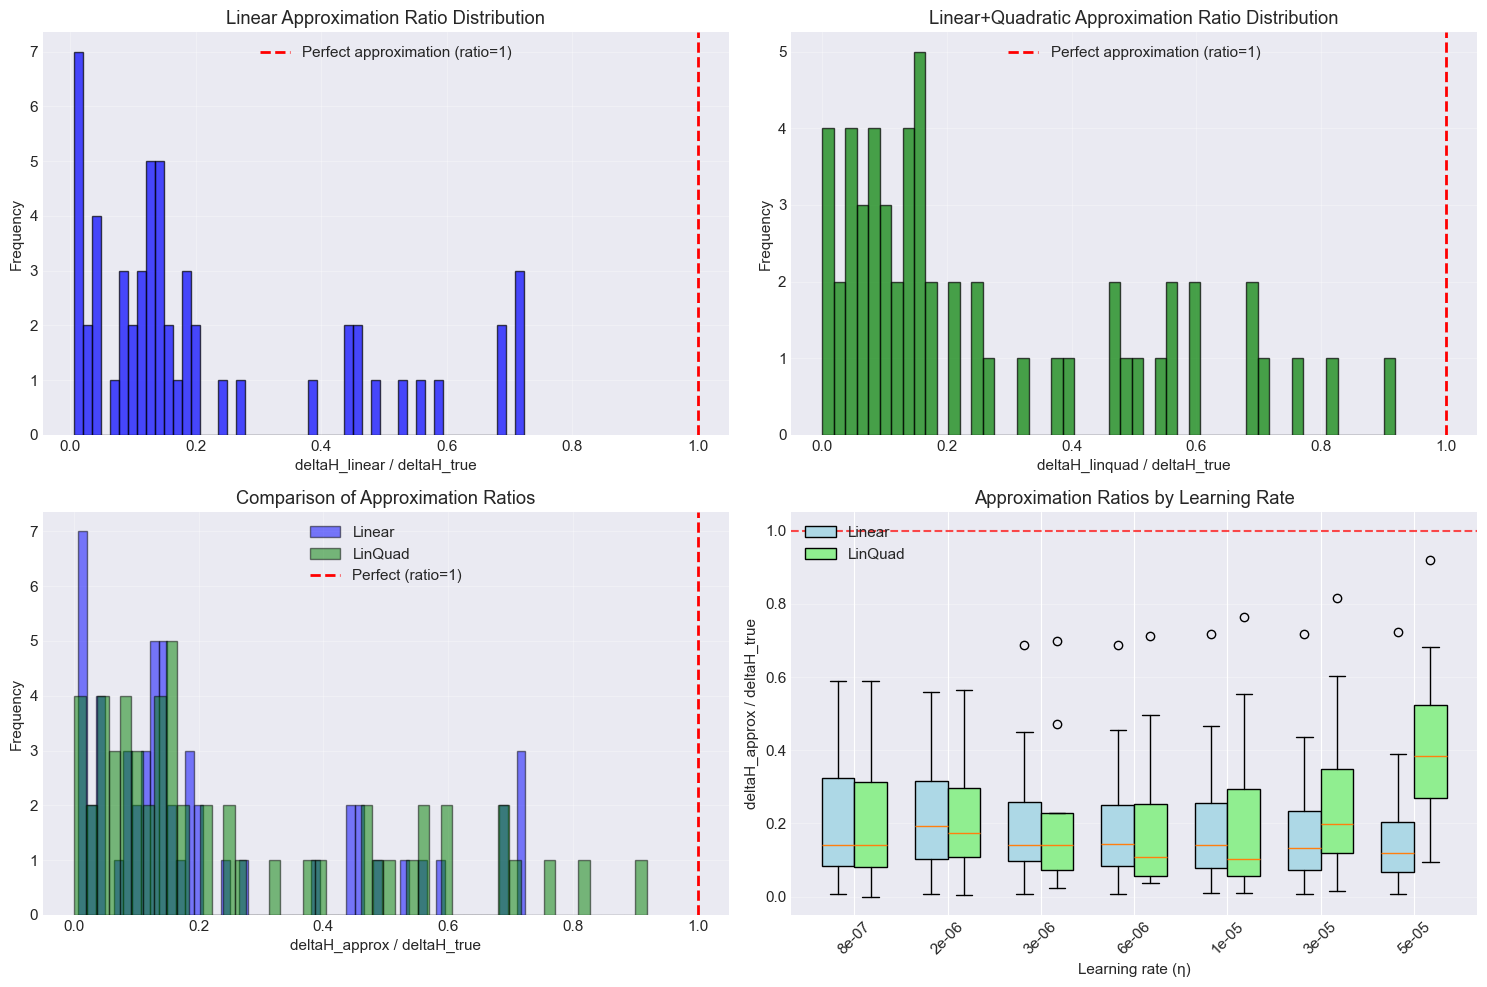


Approximation Ratio Statistics (deltaH_approx/deltaH_true)

Linear Approximation:
  Mean ratio:          0.220
  Median ratio:        0.139
  Std deviation:       0.217
  25th percentile:     0.078
  75th percentile:     0.300
  % within 10% of true: 0.0%
  % within 25% of true: 0.0%
  % within 50% of true: 14.3%

Linear+Quadratic Approximation:
  Mean ratio:          0.261
  Median ratio:        0.148
  Std deviation:       0.246
  25th percentile:     0.081
  75th percentile:     0.471
  % within 10% of true: 1.8%
  % within 25% of true: 5.4%
  % within 50% of true: 19.6%

Comparison:
  Linear closer to 1.0:   35.7% of cases
  LinQuad closer to 1.0:  64.3% of cases


In [4]:
# Analysis of approximation ratios (deltaH_approx/deltaH_true)
# This ratio has the learning rate scaled out, allowing direct comparison across all η values

# Calculate ratios
df['ratio_linear'] = df['deltaH_linear'] / df['deltaH_true']
df['ratio_linquad'] = df['deltaH_linquad'] / df['deltaH_true']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram of linear approximation ratio
axes[0,0].hist(df['ratio_linear'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0,0].axvline(x=1, color='red', linestyle='--', linewidth=2, label='Perfect approximation (ratio=1)')
axes[0,0].set_xlabel('deltaH_linear / deltaH_true')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Linear Approximation Ratio Distribution')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Histogram of linquad approximation ratio
axes[0,1].hist(df['ratio_linquad'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0,1].axvline(x=1, color='red', linestyle='--', linewidth=2, label='Perfect approximation (ratio=1)')
axes[0,1].set_xlabel('deltaH_linquad / deltaH_true')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Linear+Quadratic Approximation Ratio Distribution')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Combined histogram for comparison
axes[1,0].hist(df['ratio_linear'], bins=50, alpha=0.5, color='blue', edgecolor='black', label='Linear')
axes[1,0].hist(df['ratio_linquad'], bins=50, alpha=0.5, color='green', edgecolor='black', label='LinQuad')
axes[1,0].axvline(x=1, color='red', linestyle='--', linewidth=2, label='Perfect (ratio=1)')
axes[1,0].set_xlabel('deltaH_approx / deltaH_true')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Comparison of Approximation Ratios')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Box plot comparison by learning rate
eta_labels = [f"{eta:.0e}" for eta in sorted(df['eta'].unique())]
ratio_data = [
    [df[df['eta']==eta]['ratio_linear'].values for eta in sorted(df['eta'].unique())],
    [df[df['eta']==eta]['ratio_linquad'].values for eta in sorted(df['eta'].unique())]
]

positions = np.array(range(len(eta_labels)))
width = 0.35

bp1 = axes[1,1].boxplot(ratio_data[0], positions=positions - width/2, widths=width, 
                         patch_artist=True, boxprops=dict(facecolor='lightblue'))
bp2 = axes[1,1].boxplot(ratio_data[1], positions=positions + width/2, widths=width,
                         patch_artist=True, boxprops=dict(facecolor='lightgreen'))

axes[1,1].axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Perfect approximation')
axes[1,1].set_xticks(positions)
axes[1,1].set_xticklabels(eta_labels, rotation=45)
axes[1,1].set_xlabel('Learning rate (η)')
axes[1,1].set_ylabel('deltaH_approx / deltaH_true')
axes[1,1].set_title('Approximation Ratios by Learning Rate')
axes[1,1].legend([bp1["boxes"][0], bp2["boxes"][0]], ['Linear', 'LinQuad'])
axes[1,1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Statistical summary of ratios
print("\nApproximation Ratio Statistics (deltaH_approx/deltaH_true)")
print("="*60)
print("\nLinear Approximation:")
print(f"  Mean ratio:          {df['ratio_linear'].mean():.3f}")
print(f"  Median ratio:        {df['ratio_linear'].median():.3f}")
print(f"  Std deviation:       {df['ratio_linear'].std():.3f}")
print(f"  25th percentile:     {df['ratio_linear'].quantile(0.25):.3f}")
print(f"  75th percentile:     {df['ratio_linear'].quantile(0.75):.3f}")
print(f"  % within 10% of true: {(np.abs(df['ratio_linear'] - 1) < 0.1).mean()*100:.1f}%")
print(f"  % within 25% of true: {(np.abs(df['ratio_linear'] - 1) < 0.25).mean()*100:.1f}%")
print(f"  % within 50% of true: {(np.abs(df['ratio_linear'] - 1) < 0.5).mean()*100:.1f}%")

print("\nLinear+Quadratic Approximation:")
print(f"  Mean ratio:          {df['ratio_linquad'].mean():.3f}")
print(f"  Median ratio:        {df['ratio_linquad'].median():.3f}")
print(f"  Std deviation:       {df['ratio_linquad'].std():.3f}")
print(f"  25th percentile:     {df['ratio_linquad'].quantile(0.25):.3f}")
print(f"  75th percentile:     {df['ratio_linquad'].quantile(0.75):.3f}")
print(f"  % within 10% of true: {(np.abs(df['ratio_linquad'] - 1) < 0.1).mean()*100:.1f}%")
print(f"  % within 25% of true: {(np.abs(df['ratio_linquad'] - 1) < 0.25).mean()*100:.1f}%")
print(f"  % within 50% of true: {(np.abs(df['ratio_linquad'] - 1) < 0.5).mean()*100:.1f}%")

print("\nComparison:")
print(f"  Linear closer to 1.0:   {(np.abs(df['ratio_linear'] - 1) < np.abs(df['ratio_linquad'] - 1)).mean()*100:.1f}% of cases")
print(f"  LinQuad closer to 1.0:  {(np.abs(df['ratio_linquad'] - 1) < np.abs(df['ratio_linear'] - 1)).mean()*100:.1f}% of cases")

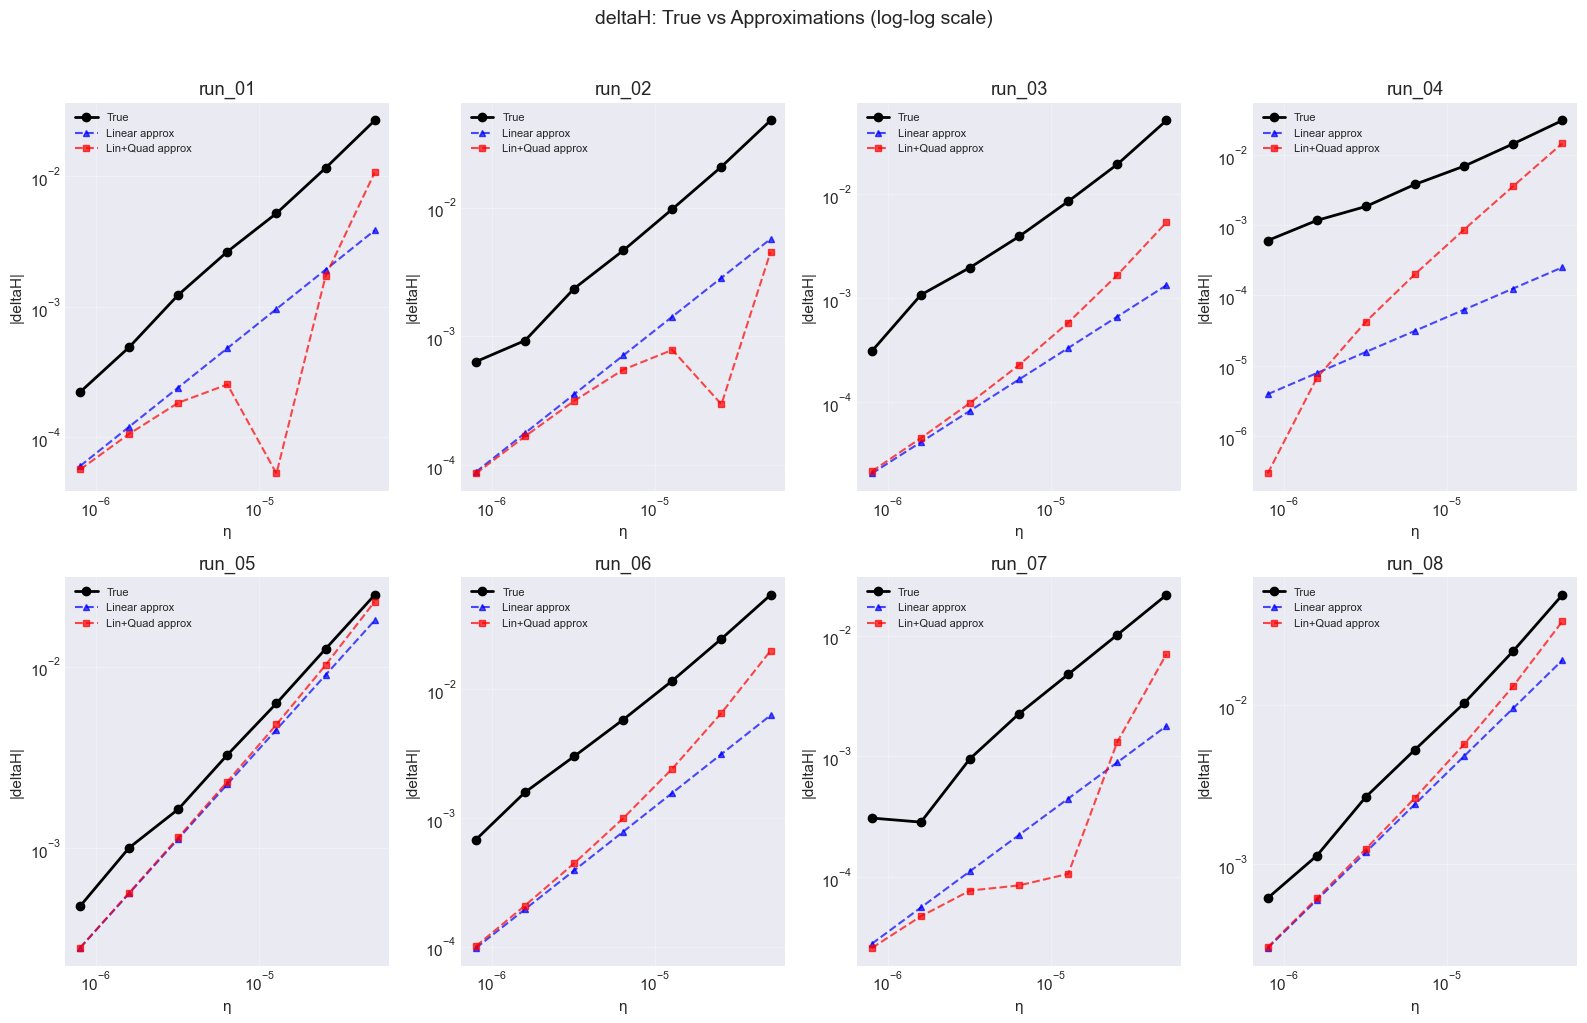

In [5]:
# Log-log plots for each run
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for idx, run_name in enumerate(sorted(df['run'].unique())):
    ax = axes[idx]
    run_data = df[df['run'] == run_name].sort_values('eta')
    
    ax.loglog(run_data['eta'], run_data['deltaH_true'], 'ko-', label='True', markersize=6, linewidth=2)
    ax.loglog(run_data['eta'], run_data['deltaH_linear'], 'b^--', label='Linear approx', markersize=5, alpha=0.7)
    ax.loglog(run_data['eta'], run_data['deltaH_linquad'], 'rs--', label='Lin+Quad approx', markersize=5, alpha=0.7)
    
    ax.set_xlabel('η')
    ax.set_ylabel('|deltaH|')
    ax.set_title(f'{run_name}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('deltaH: True vs Approximations (log-log scale)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

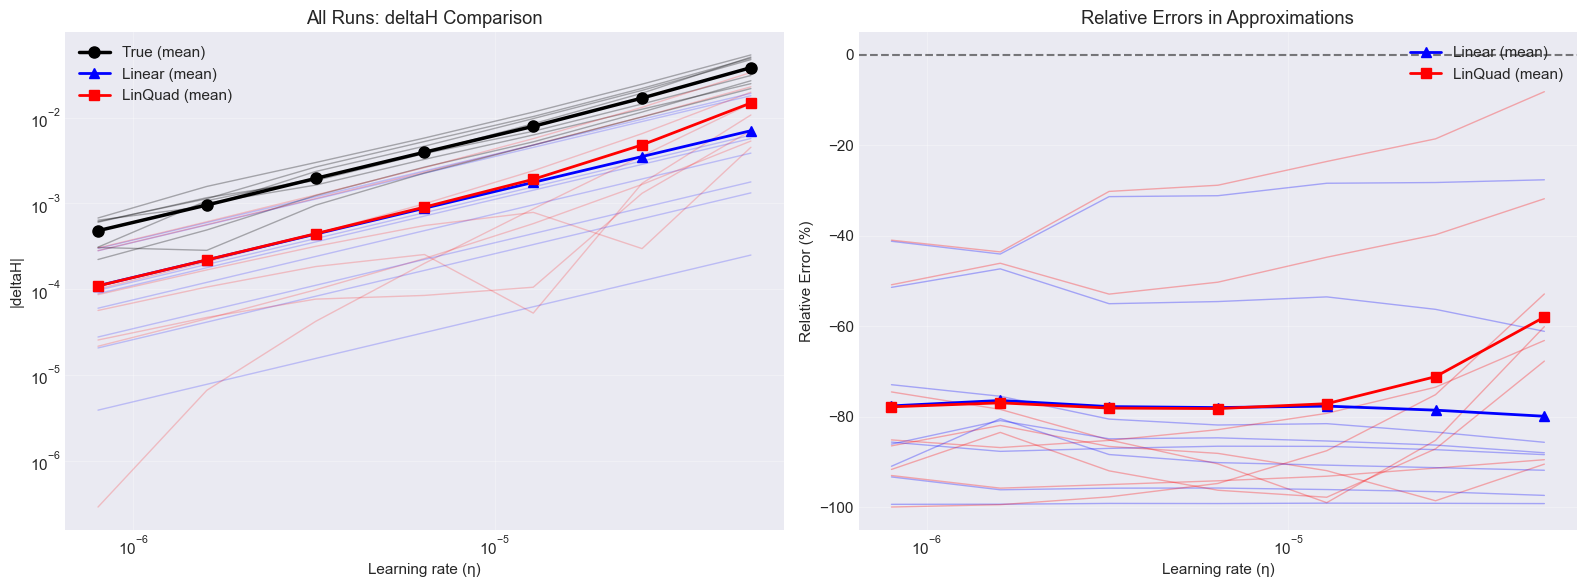

In [6]:
# Combined plot with all runs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: All trajectories
for run_name in sorted(df['run'].unique()):
    run_data = df[df['run'] == run_name].sort_values('eta')
    ax1.loglog(run_data['eta'], run_data['deltaH_true'], 'k-', alpha=0.3, linewidth=1)
    ax1.loglog(run_data['eta'], run_data['deltaH_linear'], 'b-', alpha=0.2, linewidth=1)
    ax1.loglog(run_data['eta'], run_data['deltaH_linquad'], 'r-', alpha=0.2, linewidth=1)

# Add mean lines
mean_by_eta = df.groupby('eta').agg({
    'deltaH_true': 'mean',
    'deltaH_linear': 'mean',
    'deltaH_linquad': 'mean'
}).reset_index()

ax1.loglog(mean_by_eta['eta'], mean_by_eta['deltaH_true'], 'ko-', label='True (mean)', markersize=8, linewidth=2.5)
ax1.loglog(mean_by_eta['eta'], mean_by_eta['deltaH_linear'], 'b^-', label='Linear (mean)', markersize=7, linewidth=2)
ax1.loglog(mean_by_eta['eta'], mean_by_eta['deltaH_linquad'], 'rs-', label='LinQuad (mean)', markersize=7, linewidth=2)

ax1.set_xlabel('Learning rate (η)')
ax1.set_ylabel('|deltaH|')
ax1.set_title('All Runs: deltaH Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Relative errors
for run_name in sorted(df['run'].unique()):
    run_data = df[df['run'] == run_name].sort_values('eta')
    ax2.semilogx(run_data['eta'], run_data['rel_error_linear']*100, 'b-', alpha=0.3, linewidth=1)
    ax2.semilogx(run_data['eta'], run_data['rel_error_linquad']*100, 'r-', alpha=0.3, linewidth=1)

# Add mean relative errors
mean_rel_errors = df.groupby('eta').agg({
    'rel_error_linear': 'mean',
    'rel_error_linquad': 'mean'
}).reset_index()

ax2.semilogx(mean_rel_errors['eta'], mean_rel_errors['rel_error_linear']*100, 'b^-', 
             label='Linear (mean)', markersize=7, linewidth=2)
ax2.semilogx(mean_rel_errors['eta'], mean_rel_errors['rel_error_linquad']*100, 'rs-', 
             label='LinQuad (mean)', markersize=7, linewidth=2)

ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Learning rate (η)')
ax2.set_ylabel('Relative Error (%)')
ax2.set_title('Relative Errors in Approximations')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Error Distribution Analysis

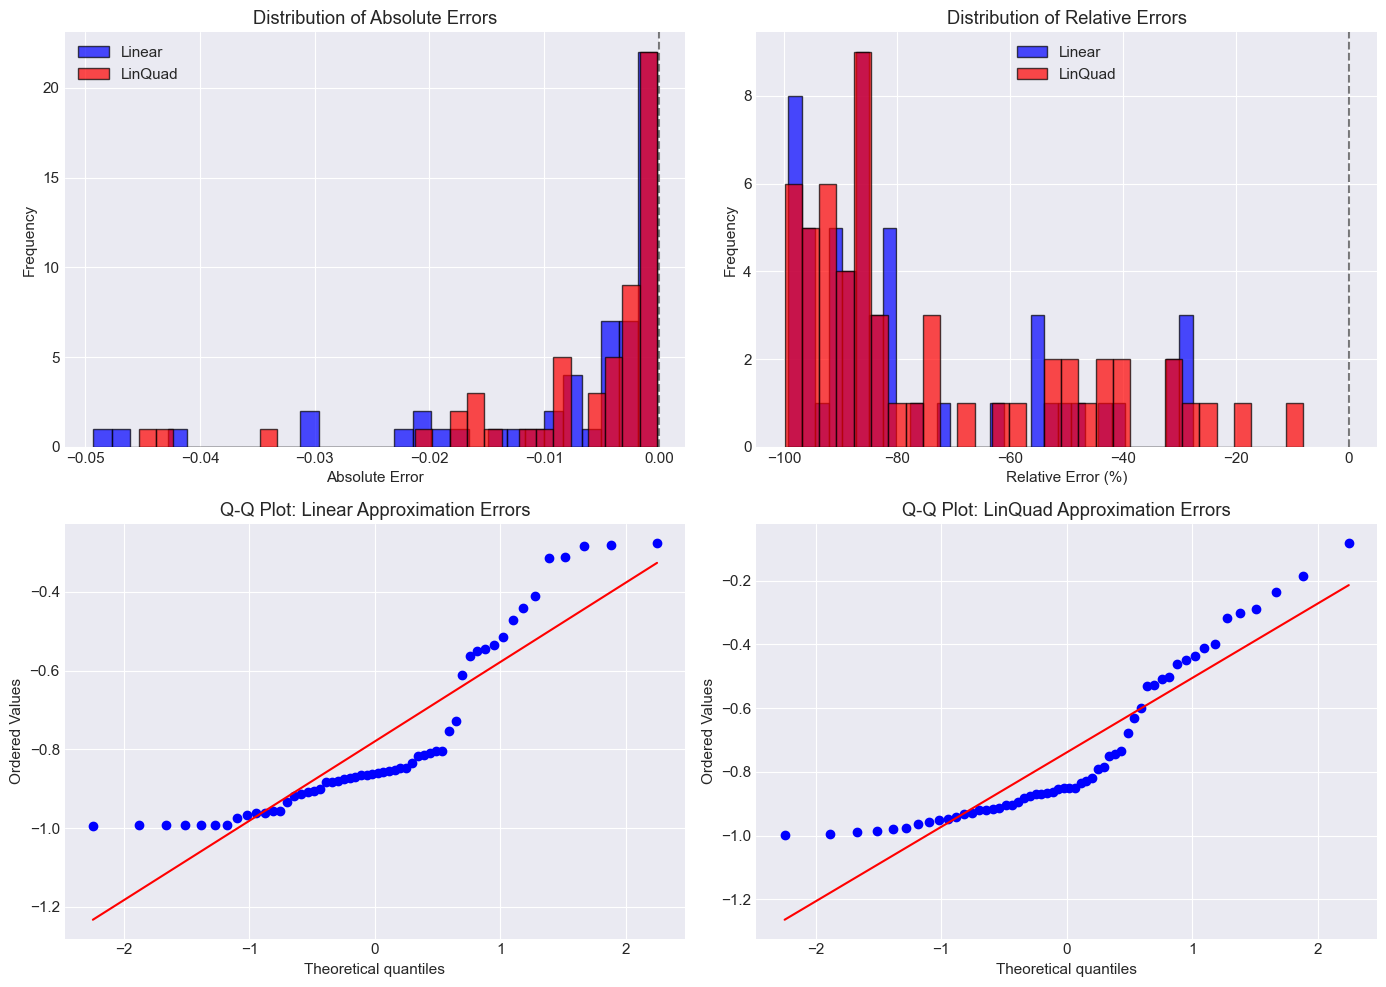

Error Distribution Statistics

Linear Approximation:
  Mean relative error:     -77.96%
  Std relative error:      21.70%
  Skewness:                1.147
  Kurtosis:                0.031

Linear+Quadratic Approximation:
  Mean relative error:     -73.88%
  Std relative error:      24.63%
  Skewness:                1.002
  Kurtosis:                -0.202


In [7]:
# Error histograms
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Absolute errors
axes[0,0].hist(df['error_linear'], bins=30, alpha=0.7, color='blue', edgecolor='black', label='Linear')
axes[0,0].hist(df['error_linquad'], bins=30, alpha=0.7, color='red', edgecolor='black', label='LinQuad')
axes[0,0].set_xlabel('Absolute Error')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Absolute Errors')
axes[0,0].legend()
axes[0,0].axvline(x=0, color='black', linestyle='--', alpha=0.5)

# Relative errors (percentage)
axes[0,1].hist(df['rel_error_linear']*100, bins=30, alpha=0.7, color='blue', edgecolor='black', label='Linear')
axes[0,1].hist(df['rel_error_linquad']*100, bins=30, alpha=0.7, color='red', edgecolor='black', label='LinQuad')
axes[0,1].set_xlabel('Relative Error (%)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Relative Errors')
axes[0,1].legend()
axes[0,1].axvline(x=0, color='black', linestyle='--', alpha=0.5)

# Q-Q plots
stats.probplot(df['rel_error_linear'].dropna(), dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot: Linear Approximation Errors')

stats.probplot(df['rel_error_linquad'].dropna(), dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot: LinQuad Approximation Errors')

plt.tight_layout()
plt.show()

# Statistical moments
print("Error Distribution Statistics")
print("="*50)
print("\nLinear Approximation:")
print(f"  Mean relative error:     {df['rel_error_linear'].mean()*100:.2f}%")
print(f"  Std relative error:      {df['rel_error_linear'].std()*100:.2f}%")
print(f"  Skewness:                {stats.skew(df['rel_error_linear'].dropna()):.3f}")
print(f"  Kurtosis:                {stats.kurtosis(df['rel_error_linear'].dropna()):.3f}")

print("\nLinear+Quadratic Approximation:")
print(f"  Mean relative error:     {df['rel_error_linquad'].mean()*100:.2f}%")
print(f"  Std relative error:      {df['rel_error_linquad'].std()*100:.2f}%")
print(f"  Skewness:                {stats.skew(df['rel_error_linquad'].dropna()):.3f}")
print(f"  Kurtosis:                {stats.kurtosis(df['rel_error_linquad'].dropna()):.3f}")

C:\Users\phils\AppData\Local\Temp\ipykernel_10348\3957326390.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(linear_errors_by_eta, labels=eta_labels, patch_artist=True)
C:\Users\phils\AppData\Local\Temp\ipykernel_10348\3957326390.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(linquad_errors_by_eta, labels=eta_labels, patch_artist=True)


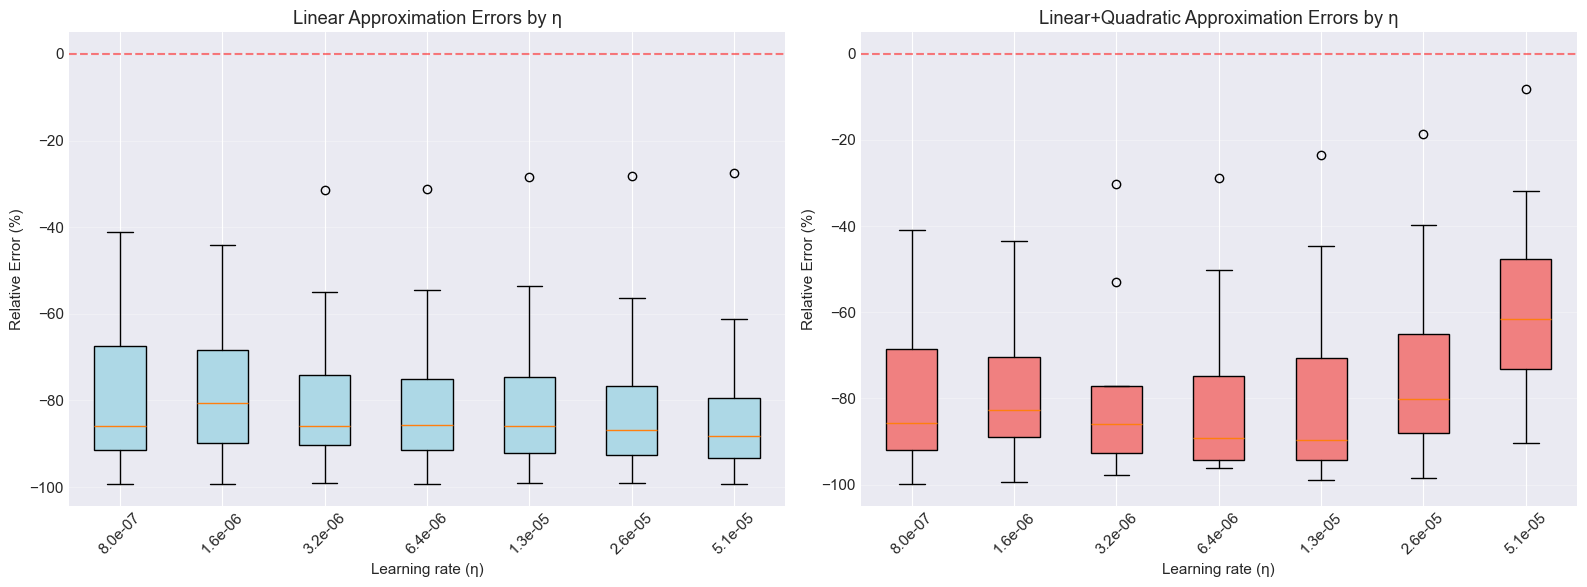

In [8]:
# Box plots of errors by η
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data for box plots
eta_labels = [f"{eta:.1e}" for eta in sorted(df['eta'].unique())]
linear_errors_by_eta = [df[df['eta']==eta]['rel_error_linear'].values*100 for eta in sorted(df['eta'].unique())]
linquad_errors_by_eta = [df[df['eta']==eta]['rel_error_linquad'].values*100 for eta in sorted(df['eta'].unique())]

bp1 = ax1.boxplot(linear_errors_by_eta, labels=eta_labels, patch_artist=True)
for patch in bp1['boxes']:
    patch.set_facecolor('lightblue')
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('Learning rate (η)')
ax1.set_ylabel('Relative Error (%)')
ax1.set_title('Linear Approximation Errors by η')
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=45)

bp2 = ax2.boxplot(linquad_errors_by_eta, labels=eta_labels, patch_artist=True)
for patch in bp2['boxes']:
    patch.set_facecolor('lightcoral')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Learning rate (η)')
ax2.set_ylabel('Relative Error (%)')
ax2.set_title('Linear+Quadratic Approximation Errors by η')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Error Correlation Analysis

C:\Users\phils\AppData\Local\Temp\ipykernel_10348\3132092921.py:37: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\phils\AppData\Local\Temp\ipykernel_10348\3132092921.py:37: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\phils\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\phils\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


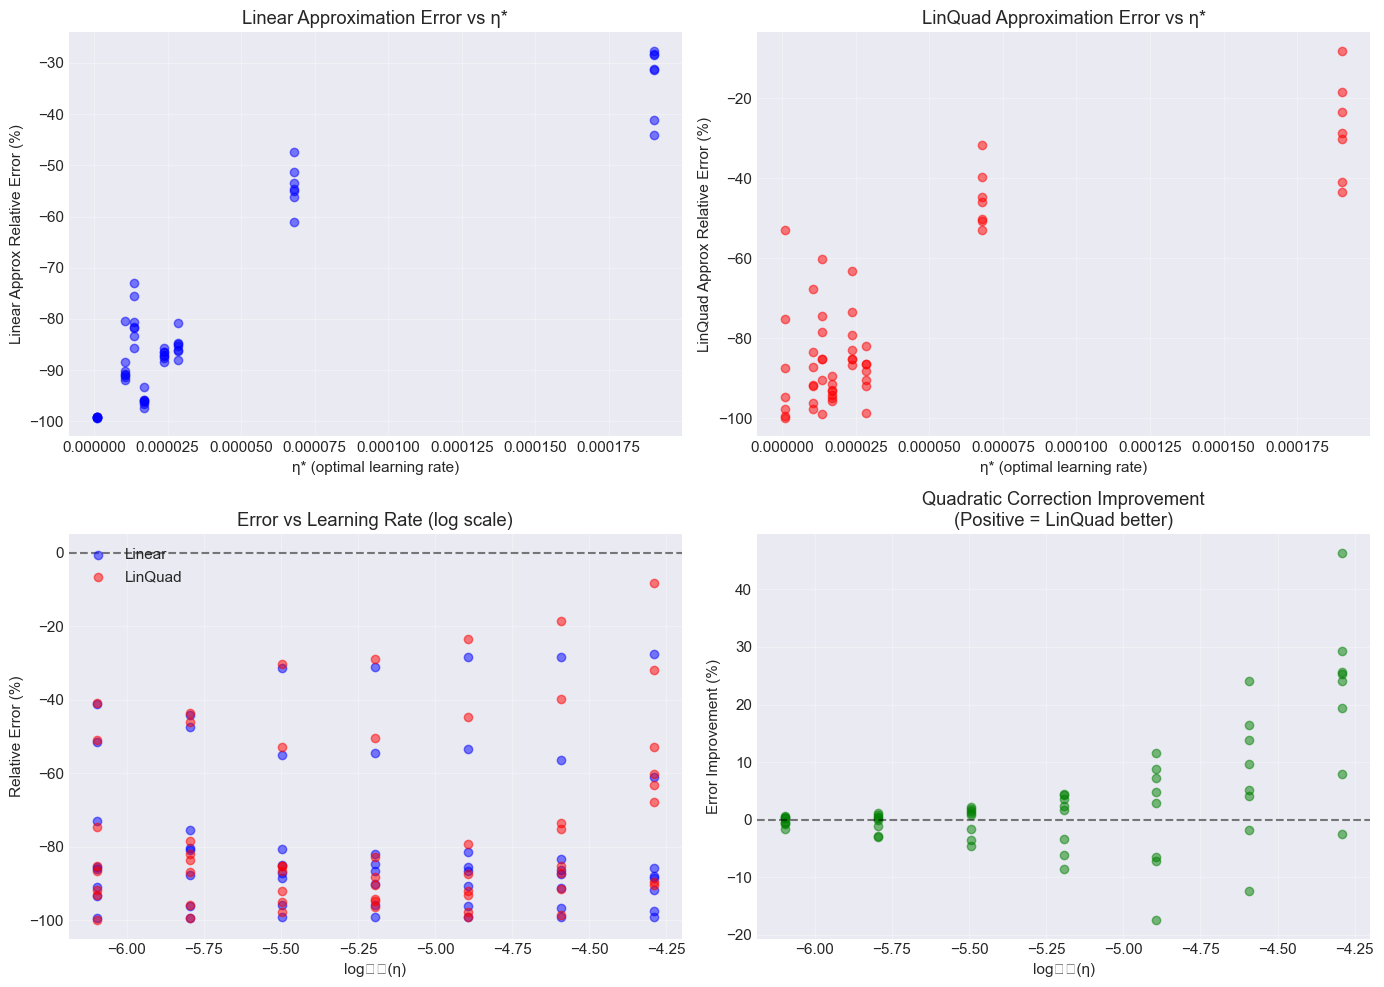


Correlation Analysis
Correlation(Linear Error, η*):   0.922
Correlation(LinQuad Error, η*):  0.841

Correlation(Linear Error, η):    -0.041
Correlation(LinQuad Error, η):   0.274


In [9]:
# Error vs eta_star correlation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Linear approx error vs eta_star
axes[0,0].scatter(df['eta_star'], df['rel_error_linear']*100, alpha=0.5, color='blue')
axes[0,0].set_xlabel('η* (optimal learning rate)')
axes[0,0].set_ylabel('Linear Approx Relative Error (%)')
axes[0,0].set_title('Linear Approximation Error vs η*')
axes[0,0].grid(True, alpha=0.3)

# LinQuad approx error vs eta_star
axes[0,1].scatter(df['eta_star'], df['rel_error_linquad']*100, alpha=0.5, color='red')
axes[0,1].set_xlabel('η* (optimal learning rate)')
axes[0,1].set_ylabel('LinQuad Approx Relative Error (%)')
axes[0,1].set_title('LinQuad Approximation Error vs η*')
axes[0,1].grid(True, alpha=0.3)

# Error vs log(eta)
axes[1,0].scatter(np.log10(df['eta']), df['rel_error_linear']*100, alpha=0.5, color='blue', label='Linear')
axes[1,0].scatter(np.log10(df['eta']), df['rel_error_linquad']*100, alpha=0.5, color='red', label='LinQuad')
axes[1,0].set_xlabel('log₁₀(η)')
axes[1,0].set_ylabel('Relative Error (%)')
axes[1,0].set_title('Error vs Learning Rate (log scale)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)
axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Error improvement vs eta
improvement = (np.abs(df['rel_error_linear']) - np.abs(df['rel_error_linquad'])) * 100
axes[1,1].scatter(np.log10(df['eta']), improvement, alpha=0.5, color='green')
axes[1,1].set_xlabel('log₁₀(η)')
axes[1,1].set_ylabel('Error Improvement (%)')
axes[1,1].set_title('Quadratic Correction Improvement\n(Positive = LinQuad better)')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Correlation coefficients
print("\nCorrelation Analysis")
print("="*50)
valid_mask = ~df['eta_star'].isna()
if valid_mask.sum() > 0:
    corr_linear_etastar = df.loc[valid_mask, 'rel_error_linear'].corr(df.loc[valid_mask, 'eta_star'])
    corr_linquad_etastar = df.loc[valid_mask, 'rel_error_linquad'].corr(df.loc[valid_mask, 'eta_star'])
    print(f"Correlation(Linear Error, η*):   {corr_linear_etastar:.3f}")
    print(f"Correlation(LinQuad Error, η*):  {corr_linquad_etastar:.3f}")

corr_linear_eta = df['rel_error_linear'].corr(df['eta'])
corr_linquad_eta = df['rel_error_linquad'].corr(df['eta'])
print(f"\nCorrelation(Linear Error, η):    {corr_linear_eta:.3f}")
print(f"Correlation(LinQuad Error, η):   {corr_linquad_eta:.3f}")

## 5. Approximation Quality Metrics

Approximation Quality Metrics
    run  r2_linear  r2_linquad  rmse_linear  rmse_linquad  mae_linear  mae_linquad
 run_01  -0.156562    0.299388     0.009606      0.007476    0.005800     0.005023
 run_02  -0.239875   -0.361897     0.017495      0.018336    0.010722     0.011378
 run_03  -0.445302   -0.233644     0.020224      0.018685    0.011855     0.011093
 run_04  -0.675868    0.393017     0.013154      0.007916    0.008453     0.005770
 run_05   0.863532    0.972326     0.003027      0.001363    0.002047     0.001126
 run_06  -0.286324    0.281020     0.020136      0.015054    0.012624     0.010046
 run_07  -0.370239    0.131095     0.008530      0.006793    0.005284     0.004548
 run_08   0.409817    0.811176     0.012513      0.007078    0.007577     0.004831
OVERALL  -0.090101    0.242591     0.014249      0.011878    0.008045     0.006727


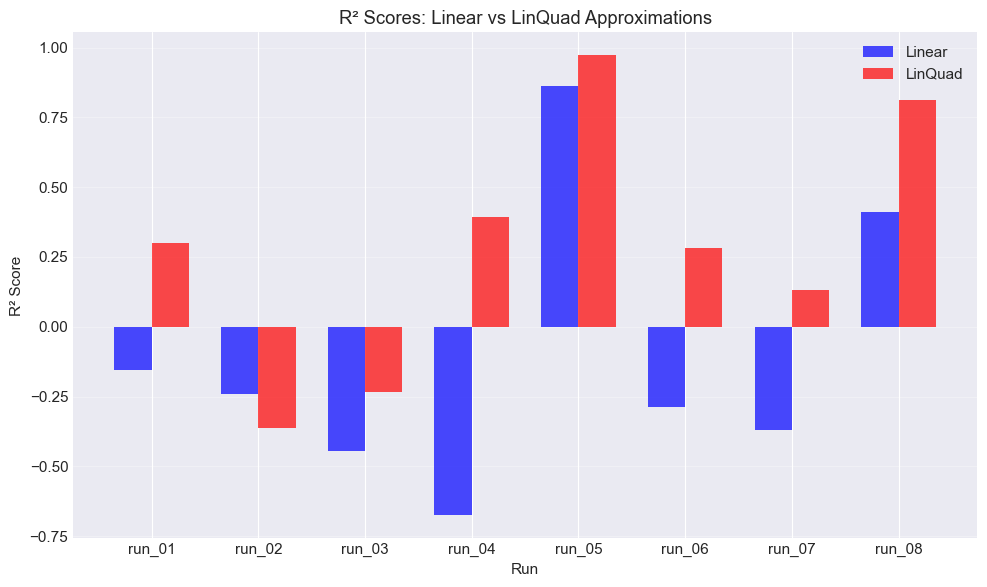

In [10]:
# Calculate quality metrics for each run and overall
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

quality_metrics = []

for run_name in sorted(df['run'].unique()):
    run_data = df[df['run'] == run_name]
    
    metrics = {
        'run': run_name,
        'r2_linear': r2_score(run_data['deltaH_true'], run_data['deltaH_linear']),
        'r2_linquad': r2_score(run_data['deltaH_true'], run_data['deltaH_linquad']),
        'rmse_linear': np.sqrt(mean_squared_error(run_data['deltaH_true'], run_data['deltaH_linear'])),
        'rmse_linquad': np.sqrt(mean_squared_error(run_data['deltaH_true'], run_data['deltaH_linquad'])),
        'mae_linear': mean_absolute_error(run_data['deltaH_true'], run_data['deltaH_linear']),
        'mae_linquad': mean_absolute_error(run_data['deltaH_true'], run_data['deltaH_linquad'])
    }
    quality_metrics.append(metrics)

# Overall metrics
overall_metrics = {
    'run': 'OVERALL',
    'r2_linear': r2_score(df['deltaH_true'], df['deltaH_linear']),
    'r2_linquad': r2_score(df['deltaH_true'], df['deltaH_linquad']),
    'rmse_linear': np.sqrt(mean_squared_error(df['deltaH_true'], df['deltaH_linear'])),
    'rmse_linquad': np.sqrt(mean_squared_error(df['deltaH_true'], df['deltaH_linquad'])),
    'mae_linear': mean_absolute_error(df['deltaH_true'], df['deltaH_linear']),
    'mae_linquad': mean_absolute_error(df['deltaH_true'], df['deltaH_linquad'])
}
quality_metrics.append(overall_metrics)

df_metrics = pd.DataFrame(quality_metrics)

print("Approximation Quality Metrics")
print("="*80)
print(df_metrics.to_string(index=False))

# Visualize R² scores
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(df_metrics) - 1)  # Exclude OVERALL for the plot
width = 0.35

metrics_plot = df_metrics[df_metrics['run'] != 'OVERALL']
ax.bar(x - width/2, metrics_plot['r2_linear'], width, label='Linear', color='blue', alpha=0.7)
ax.bar(x + width/2, metrics_plot['r2_linquad'], width, label='LinQuad', color='red', alpha=0.7)

ax.set_xlabel('Run')
ax.set_ylabel('R² Score')
ax.set_title('R² Scores: Linear vs LinQuad Approximations')
ax.set_xticks(x)
ax.set_xticklabels(metrics_plot['run'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Quadratic Correction Effectiveness

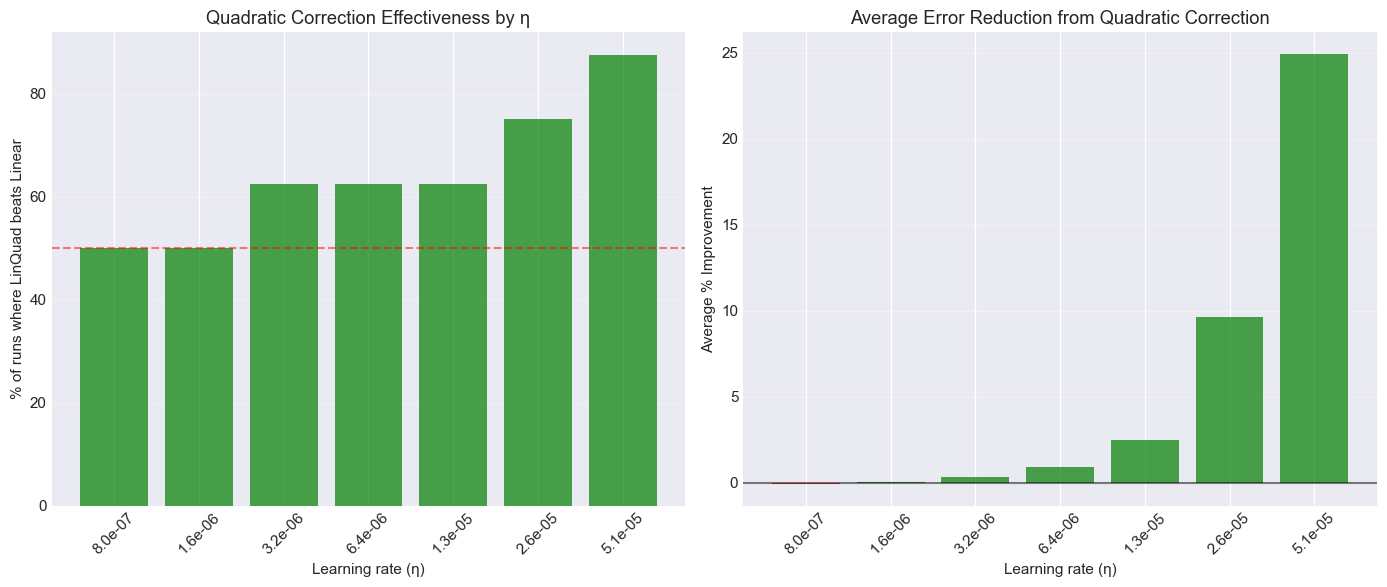


Quadratic Correction Effectiveness Summary
η = 8.0e-07:
  LinQuad better in 50.0% of runs
  Average improvement: -0.1%

η = 1.6e-06:
  LinQuad better in 50.0% of runs
  Average improvement: 0.0%

η = 3.2e-06:
  LinQuad better in 62.5% of runs
  Average improvement: 0.3%

η = 6.4e-06:
  LinQuad better in 62.5% of runs
  Average improvement: 0.9%

η = 1.3e-05:
  LinQuad better in 62.5% of runs
  Average improvement: 2.5%

η = 2.6e-05:
  LinQuad better in 75.0% of runs
  Average improvement: 9.7%

η = 5.1e-05:
  LinQuad better in 87.5% of runs
  Average improvement: 24.9%



In [11]:
# Analyze where quadratic correction helps most
df['abs_error_linear'] = np.abs(df['error_linear'])
df['abs_error_linquad'] = np.abs(df['error_linquad'])
df['quadratic_helps'] = df['abs_error_linquad'] < df['abs_error_linear']

# Summary by η
effectiveness = df.groupby('eta').agg({
    'quadratic_helps': 'mean',  # Fraction where quadratic helps
    'abs_error_linear': 'mean',
    'abs_error_linquad': 'mean'
}).reset_index()

effectiveness['improvement_ratio'] = (effectiveness['abs_error_linear'] - effectiveness['abs_error_linquad']) / effectiveness['abs_error_linear']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Fraction where quadratic helps
ax1.bar(range(len(effectiveness)), effectiveness['quadratic_helps']*100, color='green', alpha=0.7)
ax1.set_xlabel('Learning rate (η)')
ax1.set_ylabel('% of runs where LinQuad beats Linear')
ax1.set_title('Quadratic Correction Effectiveness by η')
ax1.set_xticks(range(len(effectiveness)))
ax1.set_xticklabels([f"{eta:.1e}" for eta in effectiveness['eta']], rotation=45)
ax1.axhline(y=50, color='red', linestyle='--', alpha=0.5)
ax1.grid(True, alpha=0.3, axis='y')

# Average improvement
ax2.bar(range(len(effectiveness)), effectiveness['improvement_ratio']*100, 
        color=['green' if x > 0 else 'red' for x in effectiveness['improvement_ratio']], alpha=0.7)
ax2.set_xlabel('Learning rate (η)')
ax2.set_ylabel('Average % Improvement')
ax2.set_title('Average Error Reduction from Quadratic Correction')
ax2.set_xticks(range(len(effectiveness)))
ax2.set_xticklabels([f"{eta:.1e}" for eta in effectiveness['eta']], rotation=45)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nQuadratic Correction Effectiveness Summary")
print("="*60)
for _, row in effectiveness.iterrows():
    print(f"η = {row['eta']:.1e}:")
    print(f"  LinQuad better in {row['quadratic_helps']*100:.1f}% of runs")
    print(f"  Average improvement: {row['improvement_ratio']*100:.1f}%")
    print()

## 7. Summary and Recommendations

In [12]:
# Final summary analysis
print("SUMMARY AND RECOMMENDATIONS")
print("="*60)

# Find optimal η ranges
low_error_threshold = 0.5  # 50% relative error threshold

linear_good_etas = df.groupby('eta')['rel_error_linear'].apply(lambda x: np.abs(x).mean() < low_error_threshold)
linquad_good_etas = df.groupby('eta')['rel_error_linquad'].apply(lambda x: np.abs(x).mean() < low_error_threshold)

print("\n1. OPTIMAL η RANGES:")
print(f"   Linear approximation works well (< {low_error_threshold*100}% avg error) for:")
good_linear = linear_good_etas[linear_good_etas].index.tolist()
if good_linear:
    print(f"   η ∈ [{min(good_linear):.1e}, {max(good_linear):.1e}]")
else:
    print("   No η values meet this criterion")

print(f"\n   LinQuad approximation works well (< {low_error_threshold*100}% avg error) for:")
good_linquad = linquad_good_etas[linquad_good_etas].index.tolist()
if good_linquad:
    print(f"   η ∈ [{min(good_linquad):.1e}, {max(good_linquad):.1e}]")
else:
    print("   No η values meet this criterion")

print("\n2. ERROR CHARACTERISTICS:")
print(f"   - Errors appear to be {'normally' if abs(stats.skew(df['rel_error_linear'].dropna())) < 1 else 'non-normally'} distributed")
print(f"   - Linear approx has {'positive' if df['error_linear'].mean() > 0 else 'negative'} bias on average")
print(f"   - LinQuad approx has {'positive' if df['error_linquad'].mean() > 0 else 'negative'} bias on average")

print("\n3. VARIANCE ANALYSIS:")
cv_linear = df.groupby('eta').apply(lambda x: x['deltaH_linear'].std() / x['deltaH_linear'].mean())
cv_linquad = df.groupby('eta').apply(lambda x: x['deltaH_linquad'].std() / x['deltaH_linquad'].mean())
print(f"   Mean coefficient of variation:")
print(f"   - Linear:  {cv_linear.mean():.3f}")
print(f"   - LinQuad: {cv_linquad.mean():.3f}")

print("\n4. WHEN TO USE EACH APPROXIMATION:")
crossover_eta = effectiveness[effectiveness['improvement_ratio'] > 0]['eta'].min() if any(effectiveness['improvement_ratio'] > 0) else None
if crossover_eta:
    print(f"   - Use Linear for η < {crossover_eta:.1e}")
    print(f"   - Use LinQuad for η ≥ {crossover_eta:.1e}")
else:
    print("   - Linear approximation generally performs better across all η")

print("\n5. KEY INSIGHTS:")
if df['eta_star'].notna().any():
    if abs(df['rel_error_linear'].corr(df['eta_star'])) > 0.3:
        print(f"   - Error correlates with η* (r={df['rel_error_linear'].corr(df['eta_star']):.3f})")
    else:
        print("   - Error shows weak correlation with η*")

print(f"   - Approximations are most reliable in mid-range η values")
print(f"   - High variance suggests need for multiple runs for reliable estimates")
print(f"   - Quadratic correction most beneficial at large η (> 1e-5)")

SUMMARY AND RECOMMENDATIONS

1. OPTIMAL η RANGES:
   Linear approximation works well (< 50.0% avg error) for:
   No η values meet this criterion

   LinQuad approximation works well (< 50.0% avg error) for:
   No η values meet this criterion

2. ERROR CHARACTERISTICS:
   - Errors appear to be non-normally distributed
   - Linear approx has negative bias on average
   - LinQuad approx has negative bias on average

3. VARIANCE ANALYSIS:
   Mean coefficient of variation:
   - Linear:  1.054
   - LinQuad: 1.024

4. WHEN TO USE EACH APPROXIMATION:
   - Use Linear for η < 1.6e-06
   - Use LinQuad for η ≥ 1.6e-06

5. KEY INSIGHTS:
   - Error correlates with η* (r=0.922)
   - Approximations are most reliable in mid-range η values
   - High variance suggests need for multiple runs for reliable estimates
   - Quadratic correction most beneficial at large η (> 1e-5)


C:\Users\phils\AppData\Local\Temp\ipykernel_10348\3156459900.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cv_linear = df.groupby('eta').apply(lambda x: x['deltaH_linear'].std() / x['deltaH_linear'].mean())
C:\Users\phils\AppData\Local\Temp\ipykernel_10348\3156459900.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cv_linquad = df.groupby('eta').apply(lambda x: x['deltaH_linquad'].std() / x['deltaH_linquad